### This Notebook is to test the Monte Carlo facilities of PyNeb. It is aimed to compare results obtained with keyword 'orig', which are the results using the original data, with the results obtained with keyword 'median'. All the getCrossTemDen are made using Machine Learning. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn

In [2]:
%load_ext autoreload
%aimport pipeline
%autoreload 1

In [3]:
pn.log_.level = 2
data_dir='/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/ngc6778_maps/ngc6778_long_maps/'
image_dir=data_dir+'/linemaps/'
image_name='ngc6778_MUSE_'
PL = pipeline.PipeLine(data_dir = '/Users/christophemorisset/DATA/MUSE_Jorge/hektor_fits/ngc6778_maps/ngc6778_long_maps',
                       name = 'ngc6778_MUSE_*.fits', error_str='error')
PL.add_MC(50)
PL.obs.data_shape

warng EmissionLine: line 7004A for atom O4 not valid
warng EmissionLine: line 4641A for atom N2r not valid
warng EmissionLine: line 7771A for atom O1r not valid
warng EmissionLine: line 7005A for atom Ne5 not valid
warng EmissionLine: line 5679A for atom N2r not valid
warng EmissionLine: line 7773A for atom O1r not valid
warng EmissionLine: line 7775A for atom O1r not valid
warng EmissionLine: line 8733A for atom He1r not valid
warng EmissionLine: line 6461A for atom C2r not valid
warng EmissionLine: line 5676A for atom N2r not valid
warng EmissionLine: line 5342A for atom C2r not valid


(150, 150, 51)

In [4]:
PL.obs.def_EBV()
np.nanmedian(PL.obs.extinction.cHbeta)

0.6296228609798165

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


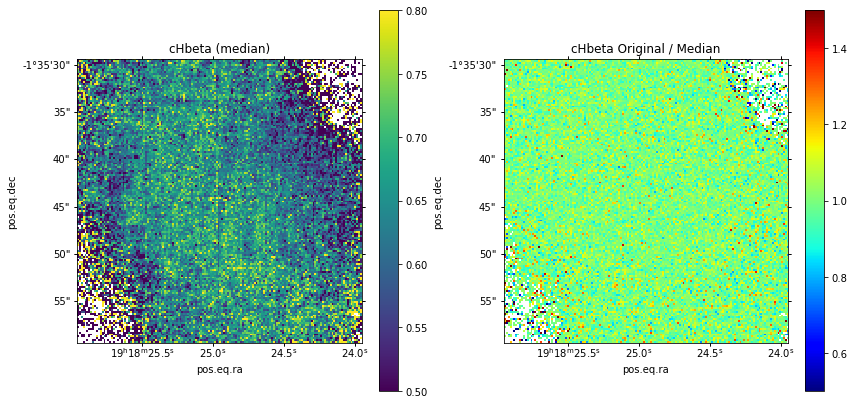

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': PL.obs.wcs})
PL.red_cor_obs(EBV_min = 0., plot_=True, ax=ax1, vmin=0.5, vmax=.8, title='cHbeta (median)',
        label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)
image = PL.get_image(PL.obs.extinction.cHbeta, type_='orig') / PL.get_image(PL.obs.extinction.cHbeta, type_='median')
PL.plot(ax=ax2, image=image, vmin=0.5, vmax=1.5, cmap='jet', title='cHbeta Original / Median',
        label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)

In [6]:
PL.obs.getSortedLines()

[Line Ar3 Ar3_7136A,
 Line Ar3 Ar3_7751A,
 Line Ar4 Ar4_4711A,
 Line Ar4 Ar4_4740A,
 Line C1 C1_8728A,
 Line C2r C2r_5342A,
 Line C2r C2r_6461A,
 Line Cl3 Cl3_5518A,
 Line Cl3 Cl3_5538A,
 Line Cl4 Cl4_7531A,
 Line Cl4 Cl4_8046A,
 Line Fe3 Fe3_4659A,
 Line H1r H1r_4861A,
 Line H1r H1r_6563A,
 Line H1r H1r_8750A,
 Line H1r H1r_9229A,
 Line He1r He1r_4713A,
 Line He1r He1r_5876A,
 Line He1r He1r_6678A,
 Line He1r He1r_7065A,
 Line He1r He1r_8733A,
 Line He2r He2r_4686A,
 Line N1 N1_5200A,
 Line N2 N2_5755A,
 Line N2 N2_6548A,
 Line N2 N2_6584A,
 Line N2r N2r_4641A,
 Line N2r N2r_5676A,
 Line N2r N2r_5679A,
 Line Ne5 Ne5_7005A,
 Line O1 O1_6300A,
 Line O1 O1_6364A,
 Line O1r O1r_7771A,
 Line O1r O1r_7773A,
 Line O1r O1r_7775A,
 Line O2 O2_7320A,
 Line O2 O2_7330A,
 Line O2r O2r_4649.13A,
 Line O2r O2r_4661.63A,
 Line O3 O3_4959A,
 Line O4 O4_7004A,
 Line S2 S2_6716A,
 Line S2 S2_6731A,
 Line S3 S3_6312A,
 Line S3 S3_9069A]

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


0.6296228609798165


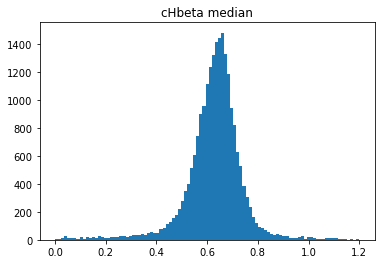

In [7]:
f, ax = plt.subplots()
ax.hist(PL.get_image(PL.obs.extinction.cHbeta, type_='median').ravel(), bins=np.linspace(0, 1.2, 100))
ax.set_title('cHbeta median')
print(np.nanmedian(PL.obs.extinction.cHbeta));

/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:218: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:226: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:182: RuntimeWarning: divide by zero encountered in true_divide
  return self.get_image(label=label[0], type_=type_) / self.get_image(label=label[1], type_=type_)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:182: RuntimeWarning: invalid value encountered in true_divide
  return self.get_image(label=label[0], type_=type_) / self.get_image(label=label[1], type_=type_)


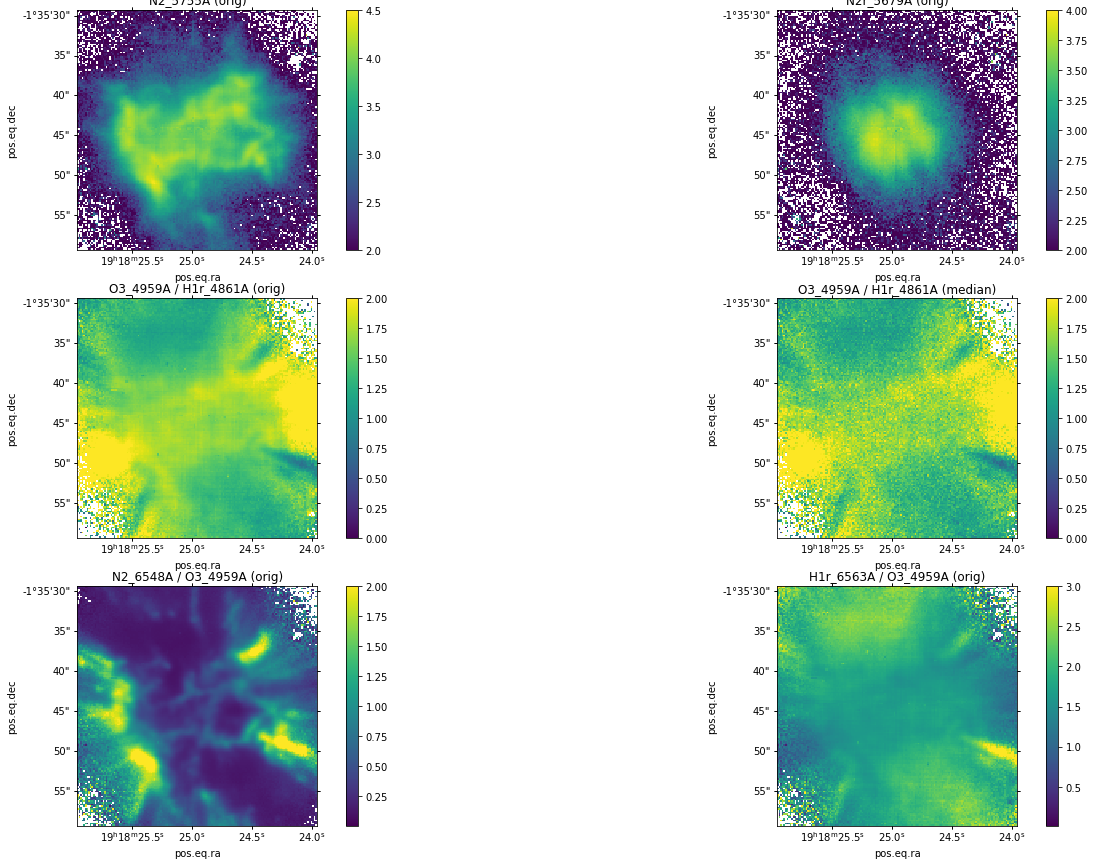

In [8]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(23, 15), subplot_kw={'projection': PL.obs.wcs})
PL.plot(ax=ax1, label='N2_5755A', type_='orig', use_log=True, vmin=2, vmax=4.5, SN_cut=None)
PL.plot(ax=ax2, label='N2r_5679A', type_='orig', use_log=True, vmin=2, vmax=4., SN_cut=None)
PL.plot(ax=ax3, label=('O3_4959A', 'H1r_4861A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax4, label=('O3_4959A', 'H1r_4861A'), type_='median', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax5, label=('N2_6548A', 'O3_4959A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax6, label=('H1r_6563A', 'O3_4959A'), type_='orig', vmax=3, SN_cut=(2.5, 2.5))

In [9]:
pn.log_.level=2
PL.make_diags()
PL.diags.diags

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: invalid value encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """ @module


{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 'OII 4649.13/4661.63': ('O2r',
  "S('4649.13')/S('4661.63')",
  "RMS([SE('4649.13'), SE('4661.63')])"),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SIII] 6312/9069': ('S3', 'L(6312)/L(9069)', 'RMS([E(9069), E(6312)])'),
 '[ClIII] 5538/5518': ('Cl3', 'L(5538)/L(5518)', 'RMS([E(5518), E(5538)])'),
 '[ArIV] 4740/4711': ('Ar4', 'L(4740)/L(4711)', 'RMS([E(4711), E(4740)])')}

In [10]:
PL.diags.ANN_inst_kwargs['verbose']=True
PL.diags.ANN_init_kwargs['activation']='tanh' #identity’, ‘logistic’, ‘tanh’, ‘relu’
PL.diags.ANN_init_kwargs['solver']= 'lbfgs' #‘lbfgs’, ‘sgd’, ‘adam’
PL.diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 20, 10)

print(PL.n_obs)
pn.log_.timer('Starting', quiet=True)
PL.add_gCTD('N2S2', '[NII] 5755/6548', '[SII] 6731/6716')
PL.add_gCTD('N2S2_84', '[NII] 5755/6584', '[SII] 6731/6716')
PL.add_gCTD('S3Cl3', '[SIII] 6312/9069', '[ClIII] 5538/5518')
PL.add_gCTD('S3S2', '[SIII] 6312/9069', '[SII] 6731/6716')
PL.add_gCTD('S3Ar4', '[SIII] 6312/9069', '[ArIV] 4740/4711')
pn.log_.timer('ANN getCrossTemDen done')

1147500


/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: invalid value encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: invalid value encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: invalid value encountered in true_divide
  """ @module
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:1: RuntimeWarning: divide by

   None: ANN getCrossTemDen done in 3.7364399433135986


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:226: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:218: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)


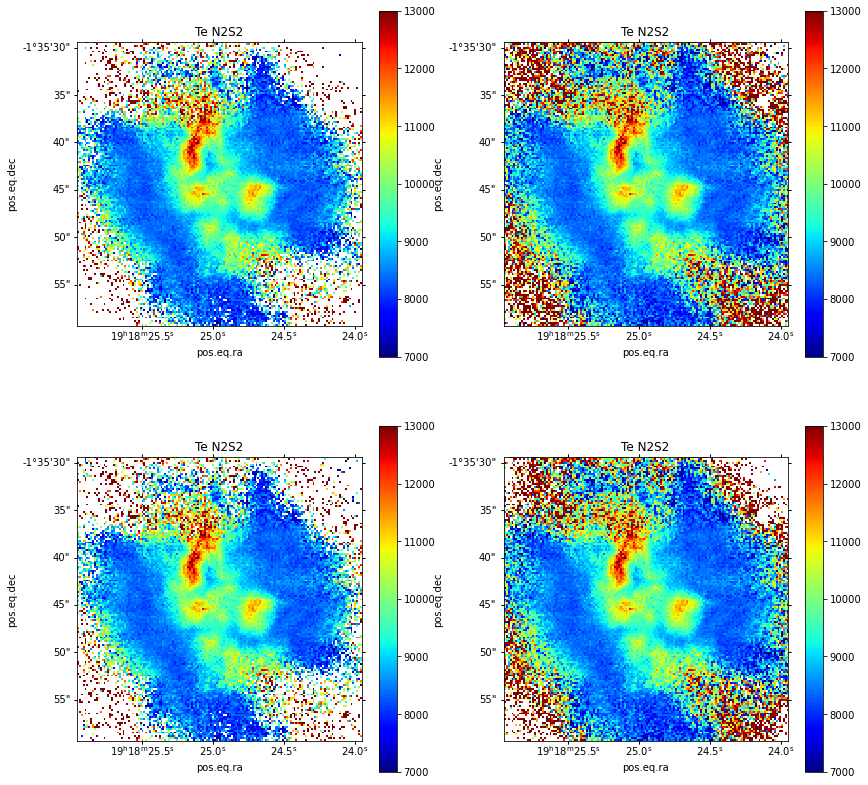

In [11]:
SN_cut = 2.5
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={'projection': PL.obs.wcs}, figsize=(14,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_5755A'), SN_cut=SN_cut)
PL.plot(ax=ax4, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S2_6716A', 'S2_6731A'), SN_cut=SN_cut)


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:226: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:218: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)


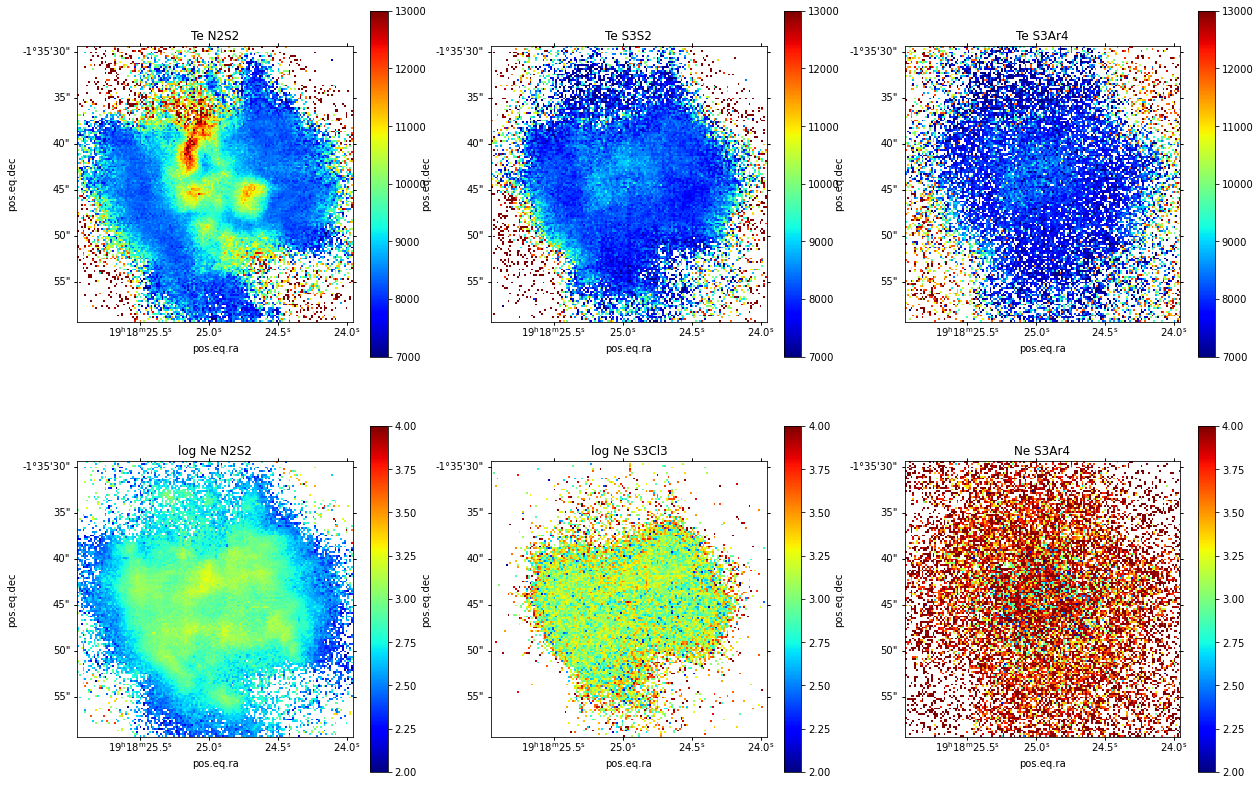

In [12]:
SN_cut = 2.5
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, subplot_kw={'projection': PL.obs.wcs}, figsize=(21,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['S3S2']['Te'], title='Te S3S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['S3Ar4']['Te'], title='Te S3Ar4', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None)
PL.plot(ax=ax4, data=np.log10(PL.TeNe['N2S2']['Ne']), title='log Ne N2S2', vmin=2, vmax=4, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax5, data=np.log10(PL.TeNe['S3Cl3']['Ne']), title='log Ne S3Cl3', vmin=2, vmax=4, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Cl3_5518A', 'Cl3_5538A'), SN_cut=SN_cut)
PL.plot(ax=ax6, data=np.log10(PL.TeNe['S3Ar4']['Ne']), title='Ne S3Ar4', vmin=2, vmax=4, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


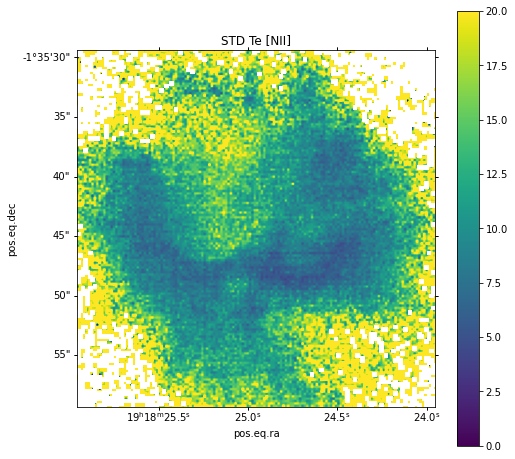

In [13]:
PL.plot_STD(data=PL.TeNe['N2S2']['Te'], vmin=0, vmax=20, title='STD Te [NII]')

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:273: RuntimeWarning: invalid value encountered in true_divide
  this_image = med / std
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:226: RuntimeWarning: divide by zero encountered in true_

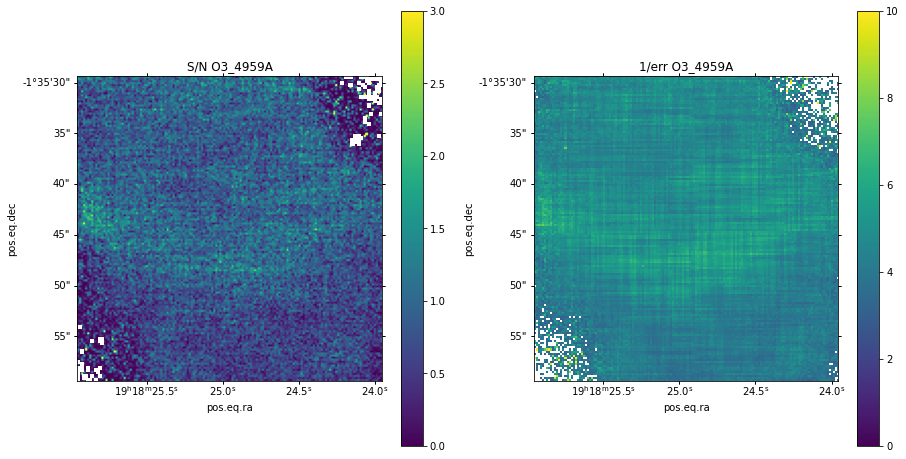

In [14]:
label = 'O3_4959A'
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': PL.obs.wcs})
PL.plot_SN(label = label, ax=ax1,vmin=0, vmax=3)
PL.plot(data = 1./PL.obs.getError()[label], type_='orig', vmin=0,vmax=10., ax=ax2, title='1/err {}'.format(label),
       label_cut=label, SN_cut=3)